In [1]:
from TriggerStudyBinaries_v2 import *

_, AllEvents = EventGenerator("all", prior=0.5)

Classifier = NNClassifier("minimal_conv2d_cut_1.0VEM/model_2")

2022-08-07 14:18:34.325765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-07 14:18:34.325787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-07 14:18:35.885688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-07 14:18:35.885707: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-07 14:18:35.885721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iklx288): /proc/driver/nvidia/version does not exist
2022-08-07 14:18:35.885920: I tensorflow/core/platform/cpu_feature_gu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 40, 1)          10        
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________



In [2]:
false_positives = []

for batch in range(AllEvents.__len__()):

    print(
        f"Fetching batch {batch + 1}/{AllEvents.__len__()}: {100 * (batch/AllEvents.__len__()):.2f}%", end="...\r")

    traces, _ = AllEvents.__getitem__(batch, full_trace=True)

    for trace in traces:

        # for i in range(0, AllEvents.length, AllEvents.window_step):
        for i in AllEvents.__sliding_window__(trace):

            start, stop = i, i + AllEvents.window_length

            window, n_sig = trace.get_trace_window((start, stop))

            if not n_sig and Classifier(window):
                false_positives.append([start, stop, trace])
                break


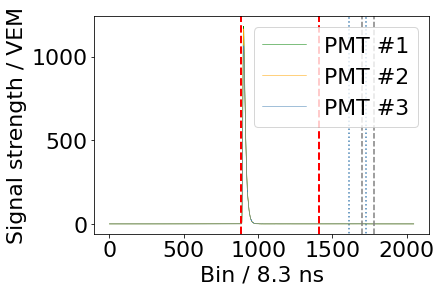

In [12]:
for start, stop, trace in false_positives[4:5]:

    plt.axvline(start, -0.3, c="steelblue", ls=":")
    plt.axvline(stop, -0.3, c="steelblue", ls=":")
    trace.__plot__()


It seems injected background is the only thing responsible for FPs, not surprising tbh.

Let's look at what *kind* of injected particles get triggered to maybe get a feeling what the NN identifies

In [18]:
AllEventsBackground = EventGenerator(["19_19.5"], split=1, force_inject=1)

not_triggered, triggered = [], []

for batch in range(AllEventsBackground.__len__()):

    print(
        f"Fetching batch {batch + 1}/{AllEventsBackground.__len__()}: {100 * (batch/AllEventsBackground.__len__()):.2f}%", end="...\r")

    traces, labels = AllEventsBackground.__getitem__(batch, full_trace=True)

    for trace in traces:

        for i in AllEventsBackground.__sliding_window__(trace):

            start, stop = i, i + AllEvents.window_length
            window, n_sig = trace.get_trace_window((start, stop))

            if Classifier(window):
                triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))
            else:
                not_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))


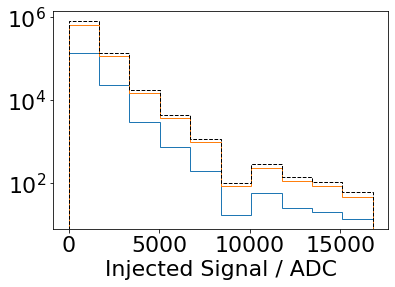

In [20]:
plt.hist(not_triggered, histtype="step", bins = 30, label="not triggered")
plt.hist(triggered, histtype="step", bins = 30, label="triggered")
plt.hist(triggered + not_triggered, histtype="step", bins = 30, label="all injected", color = "k", ls="--")
plt.xlabel("Injected Signal / ADC")
plt.yscale("log")

plt.legend()
